# Learning

In [753]:
#    #Imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import callbacks

#    #Paths
DATA_PATH = "C:/Users/User/Documents/SISE/"
COORD_STATIC_DATA_PATH = DATA_PATH + "pomiary/prepared/coordinates_data_static_merged.csv"
REF_STATIC_DATA_PATH = DATA_PATH + "pomiary/prepared/reference_data_static_merged.csv"
COORD_DYNAMIC_DATA_PATH = DATA_PATH + "pomiary/prepared/coordinates_data_dynamic_merged.csv"
REF_DYNAMIC_DATA_PATH = DATA_PATH + "pomiary/prepared/reference_data_dynamic_merged.csv"
MODEL_DIR = "models/best_model.hdf5"
MODEL_WEIGHTS_PATH = "models/trained_weights.hdf5"
PROJECT_PATH = "C:/Users/User/Documents/SISE/"

#    #Model parameters
BATCH_SIZE = 512
N_EPOCHS = 200

#    #Automatic removing models in case of re-learning
if os.path.exists(MODEL_DIR):
    os.remove(MODEL_DIR)

if os.path.exists(MODEL_WEIGHTS_PATH):
    os.remove(MODEL_WEIGHTS_PATH)
    
 #    #Creating necessary directory
if not os.path.exists("models"):
    os.mkdir("models")

In [734]:
#    #Checking GPU availability for more computing power
print("Tensorflow version: ", tf.__version__)

if tf.test.is_built_with_cuda():
    physical_device = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_device[0], True)
    print(len(physical_device), " GPU is avaiable ",)
    print("Tensorflow with NVIDIA CUDA support.")
else:
    print("Tensorflow without NVIDIA CUDA support.")

Tensorflow version:  2.3.0
1  GPU is avaiable 
Tensorflow with NVIDIA CUDA support.


In [735]:
#    #Functions
def plot_results(model_learning_process, metric='mean_squared_error'):
    metric = metric
    val_metric = 'val_' + metric
    
    accuracy = model_learning_process.history[metric]
    val_accuracy = model_learning_process.history[val_metric]
    loss = model_learning_process.history['loss']
    val_loss = model_learning_process.history['val_loss']
    epochs = range(1, len(accuracy) + 1)

    fig, axs = plt.subplots(1, 2, figsize = (12, 4))
    axs[0].plot(epochs, accuracy, 'b', label = 'Training MSE')
    axs[0].plot(epochs, val_accuracy, 'r', label = 'Validation MSE')
    axs[0].set_title('Model MSE')
    axs[0].set(xlabel = 'Epochs', ylabel = 'MSE')
    axs[0].legend()
    
    axs[1].plot(epochs, loss, 'b', label = 'Training loss')
    axs[1].plot(epochs, val_loss, 'r', label = 'Validation loss')
    axs[1].set_title('Model loss')
    axs[1].set(xlabel = 'Epochs', ylabel = 'Loss')
    axs[1].legend()
    
def create_nnetwork_block_1(input_tensor):
    x = layers.Lambda(lambda x: x, output_shape=(1,))(input_tensor)
    x = layers.Dense(1, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(64, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(128, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(256, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(512, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(128, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(128, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(128, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(64, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(1)(x)
    
    return x

def create_nnetwork_block_2(input_tensor):
    x = layers.Lambda(lambda x: x, output_shape=(1,))(input_tensor)
    x = layers.Dense(1, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(128, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(256, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(512, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(512, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(512, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(256, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(256, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(128, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(64, activation="elu", kernel_initializer="he_normal")(x)
    x = layers.Dense(1)(x)
    
    return x

def count_errors(predictions, references):
    errors = []
    for i in range(len(predictions)):
        tmp_x = references[i][0] - predictions[i][0]
        tmp_y = references[i][1] - predictions[i][1]
        errors.append(np.sqrt(tmp_x ** 2 + tmp_y ** 2))
    return errors

def ecdf(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return [x, y]

In [736]:
#    #Reading data from files
coordinates_static_data = pd.read_csv(COORD_STATIC_DATA_PATH)
reference_static_data = pd.read_csv(REF_STATIC_DATA_PATH)
#    #Creating arrays with read data
coordinates_static_data = np.array(coordinates_static_data, dtype="float32")
reference_static_data = np.array(reference_static_data, dtype="float32")

In [737]:
#    #Splitting arrays and shuffling their data for better learning
coordinates_learn, coordinates_value, reference_learn, reference_value = train_test_split(coordinates_static_data, reference_static_data, shuffle=True, random_state=128)

coordinates_learn_1, coordinates_learn_2 = coordinates_learn[:,0], coordinates_learn[:,1]
coordinates_value_1, coordinates_value_2 = coordinates_value[:,0], coordinates_value[:,1]

In [738]:
#    #Displaying shape of arrays
coordinates_learn.shape, coordinates_value.shape, reference_learn.shape, reference_value.shape

((84664, 2), (28222, 2), (84664, 2), (28222, 2))

In [739]:
#    #Instantiation a Keras tensor that allow to build a Keras model by knowing the input shape
input_layer_1 = layers.Input((1,))
input_layer_2 = layers.Input((1,))
#    #Creating two blocks of neural network with specified hidden layers and neurons in them
nnetwork_block_1 = create_nnetwork_block_1(input_layer_1)
nnetwork_block_2 = create_nnetwork_block_2(input_layer_2)
#    #Merging two blocks to create one output for whole neural network
nnetwork_merged = layers.Concatenate(axis=1)([nnetwork_block_1, nnetwork_block_2])
#    #Groups the layers into an object with learning and conclusion features.
model = tf.keras.models.Model(inputs=[input_layer_1, input_layer_2], outputs=[nnetwork_merged])
#    #Preview a summary of the network.
model.summary()

Model: "functional_123"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_124 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_123 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_123 (Lambda)             (None, 1)            0           input_124[0][0]                  
__________________________________________________________________________________________________
lambda_122 (Lambda)             (None, 1)            0           input_123[0][0]                  
_____________________________________________________________________________________

In [740]:
#    #Creating parameters for callbacks:
#    #EarlyStopping - stop learning when a monitored metric has stopped improving
#    #    #monitor - monitoring value losses
#    #    #patience - number of epochs with no improvement after which training will be stopped
#    #    #mode - in 'min' mode training will stop when the quantity monitored has stopped decreasing
#    #ReduceLROnPlateau - reduce learning rate when a metric has stopped improving
#    #    #monitor - monitoring value losses
#    #    #factor - factor by which the learning rate will be reduced
#    #    #patience - number of epochs with no improvement after which learning rate will be reduced
#    #    #min_lr - lower bound on the learning rate.
#    #ModelCheckpoint - is used to save a model or weights
#    #    #filepath - path to save the model file
#    #    #monitor - monitoring value losses
#    #    #mode - the decision to overwrite the current save file based on the minimization of the monitored quantity.
#    #    #save_best_only - it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten

callback_params = [
    callbacks.EarlyStopping(monitor='val_loss', patience=8, mode="min"),
    callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor=0.1, patience=5, min_lr=0.001),
    callbacks.ModelCheckpoint(filepath=MODEL_DIR, monitor='val_loss', mode='min', save_best_only=True)
]

In [741]:
#    #Configurating the model for training
#    #    #optimizer - optimizer instance
#    #    #loss - Loss function
#    #    #metrics - List of metrics to be evaluated by the model during training and testing - MSE
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.Huber(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
#    #Training the model for a fixed number of epochs based on input and saving it
#    #    #x - input data
#    #    #y - target data
#    #    #batch_size - number of samples per numeric calculation allowing to know how to adjust the parameters of a network in a way that its output error is minimized. (gradient)
#    #    #epochs - max number of epochs to train the model
#    #    #callbacks - list of callbacks instances to apply during learning
#    #    #validation_data - data on which to evaluate the loss and any model metrics at the end of each epoch, model will not be learned on this data
#    #    #shuffle - whether to shuffle the training data before each epoch
learning_process = model.fit(x=(coordinates_learn_1, coordinates_learn_2),
                    y=reference_learn,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS,
                    callbacks = callback_params,
                    validation_data = ((coordinates_value_1, coordinates_value_2), reference_value),
                    shuffle=True)

Epoch 1/200
166/166 [==============================] - 1s 7ms/step - loss: 325.7161 - mean_squared_error: 741155.1875 - val_loss: 103.7954 - val_mean_squared_error: 22390.3809
Epoch 2/200
166/166 [==============================] - 1s 6ms/step - loss: 132.1524 - mean_squared_error: 31752.9102 - val_loss: 108.4761 - val_mean_squared_error: 23708.8379
Epoch 3/200
166/166 [==============================] - 1s 6ms/step - loss: 115.9443 - mean_squared_error: 26411.1328 - val_loss: 100.8752 - val_mean_squared_error: 21600.6055
Epoch 4/200
166/166 [==============================] - 1s 6ms/step - loss: 105.6437 - mean_squared_error: 24015.7891 - val_loss: 118.1244 - val_mean_squared_error: 26452.7676
Epoch 5/200
166/166 [==============================] - 1s 6ms/step - loss: 133.2004 - mean_squared_error: 35991.3750 - val_loss: 106.2560 - val_mean_squared_error: 23301.4238
Epoch 6/200
166/166 [==============================] - 1s 6ms/step - loss: 109.3121 - mean_squared_error: 26173.5020 - val_l

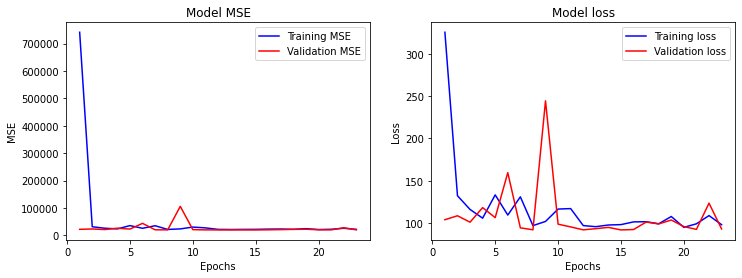

In [742]:
#    #Graphs about whole learning process
plot_results(learning_process)

In [743]:
#    #Importing merged dynamic data from .csv file
coordinates_dynamic_data = pd.read_csv(COORD_DYNAMIC_DATA_PATH)
reference_dynamic_data = pd.read_csv(REF_DYNAMIC_DATA_PATH)
#    #Merged dynamic data allocation to an array 
coordinates_dynamic = np.array(coordinates_dynamic_data, dtype="float32")
reference_dynamic = np.array(reference_dynamic_data, dtype="float32")

In [744]:
#    #Calculating The loss value & MSE values before and after model learning
mse = tf.keras.metrics.MeanSquaredError()
print(f"\nNew MSE:{model.evaluate((coordinates_dynamic[:,0], coordinates_dynamic[:,1]), reference_dynamic)[1]}\nOld MSE:{mse(reference_dynamic, coordinates_dynamic).numpy()}")

705/705 [==============================] - 1s 2ms/step - loss: 125.5366 - mean_squared_error: 32878.3516

New MSE:32878.3515625
Old MSE:43635.6484375


In [745]:
#    #Saving the best modified weights based on neural network 
model.save_weights(MODEL_WEIGHTS_PATH, save_format="hdf5")

## Results

In [746]:
#    #Generating output predictions for the dynamic samples
model_predictions = model.predict((coordinates_dynamic[:,0], coordinates_dynamic[:,1]))
#    #Counting errors for dynamic samples
errors_dynamic = count_errors(coordinates_dynamic, reference_dynamic)
#    #Counting errors for model from output predictions based on dynamic samples
errors_model_predicted = count_errors(model_predictions, reference_dynamic)

In [747]:
#    #Calculating error distribution of dynamic data
dist_dynamic = ecdf(errors_dynamic)
#    #Calculating error distribution of result obtained by using a neural network.
dist_model_predicted = ecdf(errors_model_predicted)

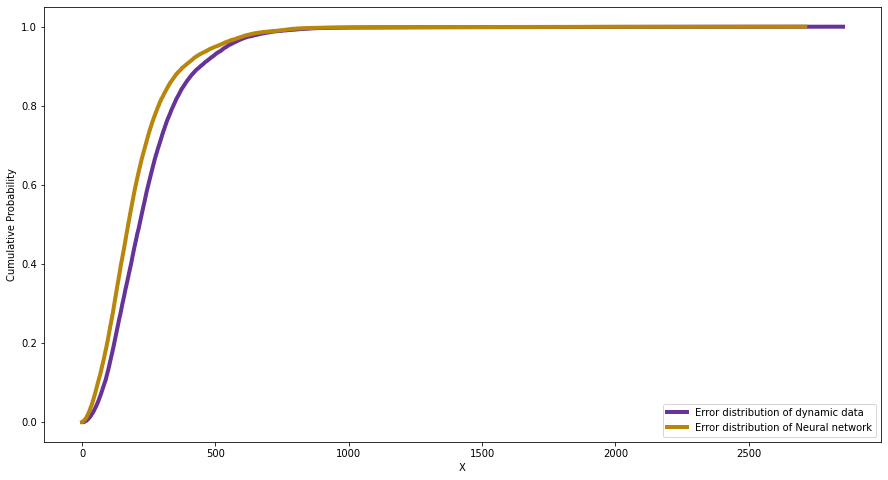

In [748]:
plt.figure(figsize=(15,8))
plt.ylabel("Cumulative Probability")
plt.xlabel("X")
plt.plot(dist_dynamic[0], dist_dynamic[1], linewidth=4, label="Error distribution of dynamic data", color='rebeccapurple')
plt.plot(dist_model_predicted[0], dist_model_predicted[1], linewidth=4, label="Error distribution of Neural network", color='darkgoldenrod')
plt.legend()
plt.show()

In [749]:
#    #Preview of weights data
model.weights

[<tf.Variable 'dense_1291/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.5628315]], dtype=float32)>,
 <tf.Variable 'dense_1291/bias:0' shape=(1,) dtype=float32, numpy=array([-0.21001785], dtype=float32)>,
 <tf.Variable 'dense_1281/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.6854974]], dtype=float32)>,
 <tf.Variable 'dense_1281/bias:0' shape=(1,) dtype=float32, numpy=array([-0.07176975], dtype=float32)>,
 <tf.Variable 'dense_1292/kernel:0' shape=(1, 128) dtype=float32, numpy=
 array([[ 2.4240425e+00,  1.6724871e+00,  2.1894152e+00,  1.8312986e+00,
          2.5478945e+00,  2.0750656e+00, -4.0174227e-02,  5.6922704e-01,
         -1.5311399e+00,  2.4791515e+00,  2.0401142e+00,  4.8821601e-01,
          1.0768461e+00,  1.1277003e+00,  6.8375909e-01,  3.7882473e-02,
          2.5659153e+00, -9.4156051e-01, -2.5230973e+00,  6.3379502e-01,
         -3.1464122e-02, -1.7733412e+00, -1.2918380e+00,  6.4766026e-01,
         -5.2970541e-01, -1.0543761e+00, -3.6080506e-01, -1.53749

In [750]:
#    #Saving weights data to .txt file
file = open("final_weights.txt", "w")
for line in model.weights:
    file.writelines(str(line))
file.close()
print("Weights saved.")

Weights saved.


In [754]:
#    #Saving Neural Network Error Distribution data to .xlsx file
final_err_dist = pd.DataFrame(dist_model_predicted).T
final_err_dist.to_excel(excel_writer = PROJECT_PATH + "NN_Error_Distribution.xlsx")
print("Neural Network Error Distribution saved.")

Neural Network Error Distribution saved.
